**Name:** LI XINYAN

**EID:** 55670594

**Kaggle Team Name:** Saaries98 / Saaries

# CS5489 - Assignment 2 - Sound Effects Tagging
Due date: see Assignment 2 on Canvas

# List of Contents

0. Import Modules

1. Helper Functions

2. Load the Data and Pre-processing
  - 2.1. Delta MFCCs
  - 2.2. Bag-of-words
  - 2.3. PCA dimension reduction

3. Download dataset for better representatio
  - 3.1 Download
  - 3.2 Convert mp3 to wav
  - 3.3 Trim silence
  - 3.4 Extract original wav signal

4. Dataset Exploration
  - 4.1 Training set overview
  - 4.2 Training set label distribution
  - 4.3 Training set wave frame distribution
  - 4.4 Training set average amplitude distribution
  - 4.5 Training set average mfcc distribution
  - 4.6 Visulize the spectrogram

5. Encode data
  - 5.1 Encode labels
  - 5.2 Normalization training set

6. CNN-based Method
  - 6.1 Model 1: complex_conv_model
  - 6.2 Model 2: simple_conv_model

7. In-class Methods
  - 7.1 Tag pre-processing
  - 7.2 Baseline
  - 7.3 MLP Classifier
  - 7.4 SVC Classifier
  - 7.5 Random Forest Classifier
  - 7.6 KNeighbors Classifier
  - 7.7 Decision Tree Classifier
  - 7.8 AdaBoost Classifier
  - 7.9 GradientBoost Classifier
  - 7.10 SGD Classifier
  - 7.11 QuadraticDiscriminantAnalysis Classifier


# Report Overview

## Things that I have tried

- **I downloaded the training set audio in order to achieve more MFCCs (a high n_mfcc) under higher sampling.**
  - The origin .mp3 file was obtained from the url under train_info\[i\]\['previews'\]\['preview-hq-mp3'\];
  - The .mp3 audio are downloaded using http requests;
  - Then, I transformed the .mp3 file into .wav format. The .wav format is supported by a convenient audio processing library librosa;
  - I used the librosa library to process the transformed .wav file, trimming the silence part, extract different features (MFCC, Chromagram, Constant-Q chromagram, Mel-scaled spectrogram);  
  - I visualized the audio and its feature using the functions offered by librosa library;

- **I explored the training dataset**
  - The evaluation results are plotted using pandas, seaborn, matplotlib library.
  - The evaluation metrics including the label distribution, the audio length distribution over labels, the wave frame distribution over labels, the average amplitude over labels;
  - I visualized the audio's wave plot, chroma_stft plot, chroma_cqt plot, chroma_cens plot, mfcc plot, melspectrogram plot, and scaled mfcc plot to discover the pattern behind different audios.

- **I used two neural network structures to perform classification on 22 labels separately**
  - The two networks have different structure, one is simpler, and the other is more complex;
  - I wanted to treat the audio as MFCC images and use networks to classify them (binary image classification problem);
  - I also tried to use the Mel-scaled spectrogram features as the networks' input;
  - Because audio data have a different length (from less than 1 second to 15 seconds), I truncated the long audio and padded the short audio;
  - The data fed to the networks are MFCC features;
  - I tried two methods to perform padding on short audio: i) pad with zero; ii) pad with itself.
  - Before feeding the training set to the networks, I tried: i) feed MFCC features; ii) feed the normalized MFCC features;
  - The neural networks did not work as well as I expected.

- **Feature Extraction on Mel-scaled spectrogram**
  - I extracted the Mel-scaled spectrogram features for each audio, and treated the Mel-scaled spectrogram features as images;
  - The images are fed to the neural networks.

- **Feature Extraction on MFCCs**
  - I tried different numbers of the cluster when performing BoW feature extraction;
  - I adjusted the parameters in TfidfTransformer;
  - I performed PCA dimension reduction on the clustering results (to reducu noise).
 
- **Classifiers**
  - I trained several classifiers (including LR classifier, SVC classifier, Random Forest classifier, Decision Tree classifier, MLP classifier, QuadraticDiscriminantAnalysis classifier, SGD Classifier, AdaBoost Classifier, GratientBoost Classifier, KNeighborsClassifier) under cross-validation, which is time-consuming;
  - To compute the pred-scores under correct format, I performed in-depth studies on usage and meaning of the return value of several functions: predict(), predict_proba(), decision_function(), evaluate();
  - The MLP performed better.
  - The decision tree-based classifiers (e.g., the random forest classifier) performed very poor on this task (I think they might be overfitted).
  - The training speed of KNeighborsClassifier is very fast, AUC is also higher;
  - I tried the QuadraticDiscriminantAnalysis classifier, it trained really fast and achieved higher AUC.

# 0. Import Modules

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import random
import datetime

from scipy import io
from scipy import stats
from pydub import AudioSegment
from IPython.display import Audio, display

from numpy import *
from sklearn import *

import os
import csv
import wave
import tqdm
import scipy
import pylab
import pickle
import librosa
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
from tqdm import tqdm_notebook
import IPython.display as ipd

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split

from keras import losses, models
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping

from tensorflow import optimizers
from tensorflow.keras.utils import Sequence, to_categorical

random.seed(100)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_wav_dir = 'train_wav/'
train_wav_trim_dir = 'train_wav_trim/'
test_wav_dir = 'test_wav/'
test_wav_trim_dir = 'test_wav_trim/'

# 1. Helper Functions

In [3]:
def showAudio(info):
    display(Audio(info['previews']['preview-hq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

In [4]:
def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

In [5]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [6]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

In [7]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [8]:
# This function plot the PCA curve
def plot_exp_ratio(ratio, title):
    explain_fig = plt.figure()
    idx = where(ratio > 0.95)[0][0]
    print("95% ratio when components are {}".format(idx))
    plt.title(title)
    plt.plot(ratio)

In [9]:
# # This function pad the input data by copying itself, using melspectrogram feature
# def prepare_mels_audio(fnames, config, data_dir):
#     max_len = config.audio_length
#     print('Audio len:', max_len)
#     X = []
    
#     for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
#         file_path = os.path.join(data_dir, fname)
        
#         a, _ = librosa.core.load(file_path, sr=config.sampling_rate)
#         d = librosa.feature.melspectrogram(a, sr=config.sampling_rate,
#                                            n_mels=128, fmax=8000)
    
#         if len(d[0]) > max_len:
#             max_offset = len(d[0]) - max_len
#             offset = np.random.randint(max_offset)
#             d = d[:, offset: (max_len + offset)]
#         else:
#             if len(d[0]) < max_len:
#                 pad_len = max_len - len(d[0])
#                 times = int(pad_len / len(d[0])) + 2
#                 d = np.tile(d, times)
#             d = d[:, : max_len]
#         X.append(d)
#     return X

In [10]:
# # This function pad the input data with zeros, using mfcc feature
# def prepare_audio(fnames, config, data_dir):
#     max_len = config.audio_length
#     print('Audio len:', max_len)
    
#     X = np.empty(shape=(len(fnames), config.n_mfcc, max_len,  1))
    
#     for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
#         file_path = os.path.join(data_dir, fname)
        
#         a, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
#         d = librosa.feature.mfcc(a, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
    
#         # duration
#         if len(d[0]) > max_len:
#             max_offset = len(d[0]) - max_len
#             offset = np.random.randint(max_offset)
#             d = d[:, offset: (max_len + offset)]
#         else:
#             if len(d[0]) < max_len:
#                 pad_len = max_len - len(d[0])
#                 pad_matrix = np.zeros(config.n_mfcc * pad_len).reshape(config.n_mfcc, pad_len)
#                 d = np.hstack((d, pad_matrix))

#         d = np.expand_dims(d, axis=-1)
#         X[i,] = d
    
#     return X

In [11]:
# This function pad the input data by copying itself, using MFCC featues
def prepare_audio(fnames, config, data_dir):
    max_len = config.audio_length
    print('Audio len:', max_len)
    
    X = np.empty(shape=(len(fnames), config.n_mfcc, max_len,  1))
    
    for i, fname in tqdm_notebook(enumerate(fnames), total=len(fnames)):
        file_path = os.path.join(data_dir, fname)
        
        a, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
        d = librosa.feature.mfcc(a, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        
        # duration
        if len(d[0]) > max_len:
            max_offset = len(d[0]) - max_len
            offset = np.random.randint(max_offset)
            d = d[:, offset: (max_len + offset)]
        else:
            if len(d[0]) < max_len:
                pad_len = max_len - len(d[0])
                times = int(pad_len / len(d[0])) + 2
                d = np.tile(d, times)
            d = d[:, : max_len]

        d = np.expand_dims(d, axis=-1)
    
#       d shape: n_mfcc * duration
        X[i,] = d
    
    return X

In [12]:
# num: plot mfcc for from index 0 to num-1
# X_train: training_set * n_mfcc * duration
def plot_scaled_mfcc(X_train, ados, num, scale = True):
    fig = plt.figure(figsize=(10, num *2))
    
    for i in range(num):
        plt.subplot(num, 1, i+1)
        tmp = X_train[i].reshape(config.n_mfcc, config.audio_length)
        
        if scale:
            mfccs = sklearn.preprocessing.scale(tmp, axis=1)
        else:
            mfccs = tmp
        
        librosa.display.specshow(mfccs, sr=config.sampling_rate, x_axis='time')
    #     plt.imshow(X_train[i].reshape(X_train[0].shape[0], X_train[0].shape[1]))

        plt.title('scaled_mfcc: ' + ados[i])
        plt.colorbar()
        plt.tight_layout()

In [13]:
class Config(object):
    def __init__(self,
                 sampling_rate=44100, audio_duration=10, n_classes=22, 
                 learning_rate=0.001, max_epochs=20, n_mfcc=13):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.n_mfcc = n_mfcc
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.audio_length =  1 + int(np.floor(self.sampling_rate * self.audio_duration / 512))
        
#       Why /512: https://stackoverflow.com/questions/52232839/understanding-the-output-of-mfcc/52236005
        self.dim = (self.n_mfcc, self.audio_length, 1)

In [14]:
def plot_loss(history):
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()

In [15]:
def show_exmp(wav_dir, ados, idx):
    ado_exmp = wav_dir + ados[idx]

    print(ado_exmp)

    # Load wav
    y,sr = librosa.load(ado_exmp)
    print(type(y), type(sr))
    print(y.shape, sr)

    plt.figure(figsize=(10,14))

    # -------------------- Waveplot --------------------
    plt.subplot(7,1,1)
    librosa.display.waveplot(y, sr=sr)
    plt.title('wave_plot')

    # -------------------- chroma_stft --------------------
    plt.subplot(7,1,2)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma_stft, y_axis='chroma')
    plt.title('chroma_stft')
    plt.colorbar()

    # -------------------- chroma_cqt --------------------
    plt.subplot(7,1,3)
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
    librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
    plt.title('chroma_cqt')
    plt.colorbar()

    # -------------------- chroma_cens --------------------
    plt.subplot(7,1,4)
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time')
    plt.title('chroma_cens')
    plt.colorbar()

    # -------------------- mfcc --------------------
    plt.subplot(7,1,5)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = config.n_mfcc)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title('mfcc')
    plt.colorbar()

    # -------------------- melspectrogram --------------------
    plt.subplot(7,1,6)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                             y_axis='mel', fmax=8000, x_axis='time')
    plt.title('melspectrogram')
    plt.colorbar()


    # -------------------- scaled_mfcc --------------------
    plt.subplot(7,1,7)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = config.n_mfcc)
    mfccs = sklearn.preprocessing.scale(mfcc, axis=1)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title('scaled_mfcc')
    plt.colorbar()

    plt.tight_layout()

In [16]:
# plot an ROC curve using class labels and class scores
def plot_roc(tagnames, Yclasses, Yscores):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = np.mean(aucall)

    plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
    plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))

    plt.grid(True)

# 2. Load the Data and Pre-processing
The training and test data are stored in various pickle files.
The below code will load the data.

In [17]:
train_tags  = load_pickle('sound-data/train_tags.pickle3')
train_mfccs = load_pickle('sound-data/train_mfccs.pickle3')
train_info  = load_pickle('sound-data/train_info.pickle3')

test_mfccs = load_pickle('sound-data/test_mfccs.pickle3')
test_info  = load_pickle('sound-data/test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set (contains a link to the sound).
- `train_mfccs` - the MFCC features for each sound in the training set.  MFCCs are [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a type of spectral feature vector for audio.
- `train_tags` - the descriptive tags for each sound in the training set. Tags have already been stemmed.
- `test_info` - info about each sound in the test set.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the first sound in the training set, as well as the tags.

In [18]:
print(train_info[0])
print(train_mfccs[0].shape)
print(train_tags[0])

{'tags': ['metallic', 'ringing'], 'id': 552, 'analysis_frames': 'http://www.freesound.org/data/analysis/0/552_291_frames.json', 'previews': {'preview-lq-ogg': 'http://www.freesound.org/data/previews/0/552_291-lq.ogg', 'preview-hq-ogg': 'http://www.freesound.org/data/previews/0/552_291-hq.ogg', 'preview-hq-mp3': 'http://www.freesound.org/data/previews/0/552_291-hq.mp3', 'preview-lq-mp3': 'http://www.freesound.org/data/previews/0/552_291-lq.mp3'}}
(345, 13)
['metal']


and here are the MFCCs for the first sound in the training set.  The MFCC vectors are 13-dimensions each, and they are extracted using a sliding window over the sound.

(345, 13)


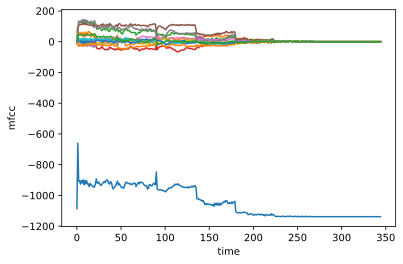

In [19]:
print(train_mfccs[0].shape)
plt.plot(train_mfccs[0]);
plt.xlabel('time')
plt.ylabel('mfcc');

['synth'] ['loop'] ['glitch']
(176, 13) (320, 13) (63, 13)


Text(0, 0.5, 'mfcc')

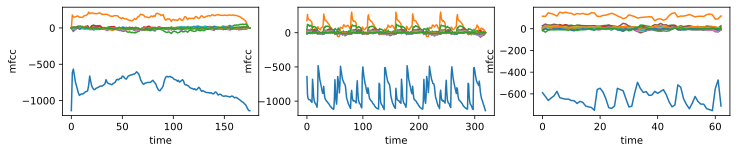

In [20]:
print(train_tags[1], train_tags[2], train_tags[3])
print(train_mfccs[1].shape, train_mfccs[2].shape, train_mfccs[3].shape)

plt.figure(figsize=(12, 2))

plt.subplot(1, 3, 1)
plt.plot(train_mfccs[1])
plt.xlabel('time')
plt.ylabel('mfcc')

plt.subplot(1, 3, 2)
plt.plot(train_mfccs[2])
plt.xlabel('time')
plt.ylabel('mfcc')

plt.subplot(1, 3, 3)
plt.plot(train_mfccs[3])
plt.xlabel('time')
plt.ylabel('mfcc')

### 2.1. Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [21]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [22]:
print('train set size(mfcc):', len(train_mfccs), len(train_mfccs[0]), len(train_mfccs[0][0]))
print('train set size(dmfcc):', len(train_dmfccs), len(train_dmfccs[0]), len(train_dmfccs[0][0]))

train set size(mfcc): 1788 345 13
train set size(dmfcc): 1788 344 26


### 2.2. Bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [23]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(391816, 26)


In [24]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=500, random_state=4487)
km.fit(all_dmfccs[0::10])
# km.cluster_centers_

KMeans(n_clusters=500, random_state=4487)

Now transform the data into BOW.

In [25]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

### 2.4. TF-IDF representation

In [26]:
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

### 2.3. PCA dimension reduction

I perform PCA dimension reduction after applying the KMeans clustering. I found that doing so can slightly improve the accuracy (noise reduction).

In [27]:
pca_model = decomposition.TruncatedSVD(n_components=499)
pca_model.fit(train_Xtf)

TruncatedSVD(n_components=499)

95% ratio when components are 285


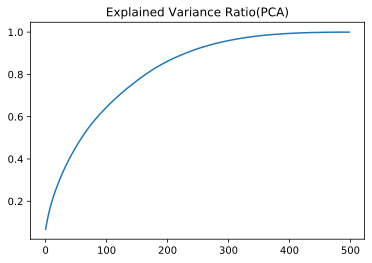

In [28]:
plot_exp_ratio(cumsum(pca_model.explained_variance_ratio_), 
               "Explained Variance Ratio(PCA)")

In [29]:
pca_500To285 = decomposition.TruncatedSVD(n_components=285)
pca_500To285.fit(train_Xtf)

train_Xtf = pca_500To285.transform(train_Xtf)
test_Xtf = pca_500To285.transform(test_Xtf)

# 3. Download dataset for better representation
- https://www.kaggle.com/msripooja/steps-to-convert-audio-clip-to-spectrogram

In [30]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [31]:
! /opt/anaconda3/bin/python -m pip install threadpool
! /opt/anaconda3/bin/python -m pip install tomorrow

## 3.1 Download

In [32]:
# # The script I used to download audio data, change the train/test 
# from urllib.request import urlretrieve
# import re
# import os
# import requests
# from numpy import *
# from sklearn import *
# from scipy import stats
# random.seed(100)
# import csv
# from scipy import io
# import pickle
# import threadpool
# import time
# from tomorrow import threads

# @threads(100)
# def download_train(url):
#     try:
#         mp3_name = url.replace('https://www.freesound.org/data/previews/', '')
#         mp3_name = mp3_name.replace('http://www.freesound.org/data/previews/', '')
#         mp3_name = mp3_name.replace('/', '-')
#         mp3_name = 'train_mp3/' + mp3_name.replace('/', '-')
        
#         if os.path.isfile(mp3_name):
#             print('Exist:', url)
#         else:
#             res = requests.get(url, timeout=10)
#             with open(mp3_name, 'ab') as file:
#                 file.write(res.content)
#                 file.flush()
#             print('Success:', url)
#     except Exception as err: 
#         print('Failed:', url, err)

# urls = []
# for i in range(len(train_info)):
#     mp3_link = train_info[i]['previews']['preview-hq-mp3']
#     urls.append(mp3_link)

# responses = [download_train(url) for url in urls]
# html = [response.text for response in responses if hasattr(response,"text")]
# print(len(urls))

In [33]:
#  @threads(100)
# def download_test(url):
#     try:
#         mp3_name = url.replace('https://www.freesound.org/data/previews/', '')
#         mp3_name = mp3_name.replace('http://www.freesound.org/data/previews/', '')
#         mp3_name = mp3_name.replace('/', '-')
#         mp3_name = 'test_mp3/' + mp3_name.replace('/', '-')
        
#         if os.path.isfile(mp3_name):
#             print('Exist:', url)
#         else:
#             res = requests.get(url)
#             with open(mp3_name, 'ab') as file:
#                 file.write(res.content)
#                 file.flush()
#             print('Success:', url)
#     except:
#         print('Failed:', url)

# urls = []
# for i in range(len(test_info)):
#     mp3_link = test_info[i]['previews']['preview-hq-mp3']
#     urls.append(mp3_link)

# responses = [download_test(url) for url in urls]
# html = [response.text for response in responses if hasattr(response,"text")]
# print(len(urls))

In [34]:
! rm -f 'train_wav/.DS_Store'
! rm -f 'test_wav/.DS_Store'

In [35]:
# Load train/test fname into array (mp3 format)
train_ados = []
test_ados = []

for i in range(len(train_info)):
    url = train_info[i]['previews']['preview-hq-mp3']
    mp3_name = url.replace('https://www.freesound.org/data/previews/', '')
    mp3_name = mp3_name.replace('http://www.freesound.org/data/previews/', '')
    mp3_name = mp3_name.replace('/', '-')
    train_ados.append(mp3_name)

for i in range(len(test_info)):
    url = test_info[i]['previews']['preview-hq-mp3']
    mp3_name = url.replace('https://www.freesound.org/data/previews/', '')
    mp3_name = mp3_name.replace('http://www.freesound.org/data/previews/', '')
    mp3_name = mp3_name.replace('/', '-')
    test_ados.append(mp3_name)

print(len(train_ados), len(test_ados))

1788 262


## 3.2 Convert mp3 to wav

In [36]:
# train_mp3_dir = 'train_mp3/'
# test_mp3_dir = 'test_mp3/'

# train_wav_dir = 'train_wav/'
# test_wav_dir = 'test_wav/'

# # convert train set
# for i, ad in tqdm_notebook(enumerate(train_ados), total=len(train_ados)):
#     sound = AudioSegment.from_mp3(train_mp3_dir + ad)
#     ad = ad.replace('.mp3', '.wav')
#     sound.export(train_wav_dir + ad, format="wav")

# # convert test set
# for i, ad in tqdm_notebook(enumerate(test_ados), total=len(test_ados)):
#     sound = AudioSegment.from_mp3(test_mp3_dir + ad)
#     ad = ad.replace('.mp3', '.wav')
#     sound.export(test_wav_dir + ad, format="wav")

In [37]:
# Load train/test fname into array (wav format)
for i in range(len(train_ados)):
    train_ados[i] = train_ados[i].replace('.mp3', '.wav')
    
for i in range(len(test_ados)):
    test_ados[i] = test_ados[i].replace('.mp3', '.wav')

print(len(train_ados), len(test_ados))

1788 262


## 3.3 Trim silence

In [38]:
# print('Strat triming silence for training set')
# for i, ad in tqdm_notebook(enumerate(train_ados), total=len(train_ados)):
#     x, sr = librosa.load(train_wav_dir + ad)
#     x, _ = librosa.effects.trim(x)
#     librosa.output.write_wav(train_wav_trim_dir + ad, x, sr)
# print('Finish triming silence for training set')

# print('Strat triming silence for test set')
# for i, ad in tqdm_notebook(enumerate(test_ados), total=len(test_ados)):
#     x, sr = librosa.load(test_wav_dir + ad)
#     x, _ = librosa.effects.trim(x)
#     librosa.output.write_wav(test_wav_trim_dir + ad, x, sr)
# print('Finish triming silence for test set')

## 3.4 Extract original wav signal

In [39]:
# config = Config(sampling_rate=16100, audio_duration=2, learning_rate=0.001, n_mfcc=13, n_classes=2)
# config = Config(sampling_rate=6000, audio_duration=2, learning_rate=0.001, n_mfcc=13, n_classes=2)
config = Config(sampling_rate=16100, audio_duration=4, learning_rate=0.001, n_mfcc=13, n_classes=2)

print('Strat pad and extract mfcc for training set:')
X_train = prepare_audio(train_ados, config, train_wav_trim_dir)

print('Strat pad and extract mfcc for test set:')
X_test = prepare_audio(test_ados, config, test_wav_trim_dir)

print('End')

Strat pad and extract mfcc for training set:
Audio len: 126


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1788 [00:00<?, ?it/s]

Strat pad and extract mfcc for test set:
Audio len: 126


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/262 [00:00<?, ?it/s]

End


# 4. Dataset Exploration
## 4.1 Training set overview

In [40]:
tmp = {'fname': {},
       'label': {}}

train_df = pd.DataFrame(tmp)
idx = 0

for i in range(len(train_ados)):
    for lab in train_tags[i]:
        fname = train_ados[i] + '-' +lab
        train_df.loc[idx]=[fname, lab]
        idx += 1

In [41]:
display(train_df)

fname   label
0               0-552_291-hq.wav-metal   metal
1                0-714_19-hq.wav-synth   synth
2                0-939_801-hq.wav-loop    loop
3            2-2320_3619-hq.wav-glitch  glitch
4              2-2838_4938-hq.wav-voic    voic
...                                ...     ...
3547  346-346340_3905081-hq.wav-effect  effect
3548  346-346341_3905081-hq.wav-effect  effect
3549  346-346343_3905081-hq.wav-effect  effect
3550  346-346346_3905081-hq.wav-effect  effect
3551  346-346349_3905081-hq.wav-effect  effect

[3552 rows x 2 columns]

In [42]:
encoder = MultiLabelBinarizer()
encoder.fit(train_tags)
X_train_labels = encoder.transform(train_tags)

print("Number of Training samples: ", len(train_info))
print("Number of Labels: ", len(encoder.classes_))
print("Unique Labels: ", encoder.classes_)

Number of Training samples:  1788
Number of Labels:  22
Unique Labels:  ['acoust' 'analog' 'bass' 'beat' 'drum' 'effect' 'electron' 'field'
 'glitch' 'guitar' 'hit' 'loop' 'machin' 'metal' 'nois' 'percuss' 'record'
 'space' 'synth' 'synthes' 'vocal' 'voic']


## 4.2 Training set label distribution

Minimum samples per label =  100
Maximum samples per label =  371


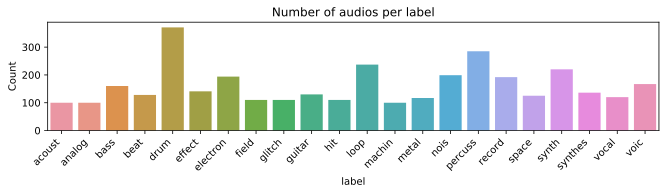

In [43]:
plt.figure(figsize=(11, 2))

labels_grouped = train_df.groupby(['label']).count()
chart = sns.barplot(x=labels_grouped.index, y=labels_grouped['fname'])

chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Number of audios per label")
chart.set_ylabel('Count')

print('Minimum samples per label = ', min(train_df['label'].value_counts()))
print('Maximum samples per label = ', max(train_df['label'].value_counts()))

## 4.3 Training set wave frame distribution

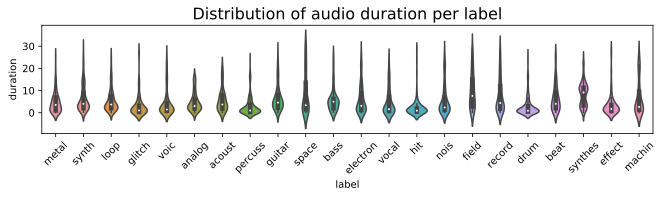

In [44]:
train_df['duration'] = train_df['fname'].apply(lambda f:
        librosa.get_duration(filename = os.path.join(train_wav_trim_dir, f.split('.wav')[0] + '.wav')))

_, ax = plt.subplots(figsize=(11, 2))
sns.violinplot(ax=ax, x='label', y='duration', data=train_df)

plt.xticks(rotation=45)
plt.title('Distribution of audio duration per label', fontsize=16)
plt.show()

In [45]:
def avg_amplitude(file):
    y, sr = librosa.load(file)
    second = []
    for s in range(0,len(y),sr):
        second.append(np.abs(y[s:s+sr]).mean())
    return sum(second)

## 4.4 Training set average amplitude distribution

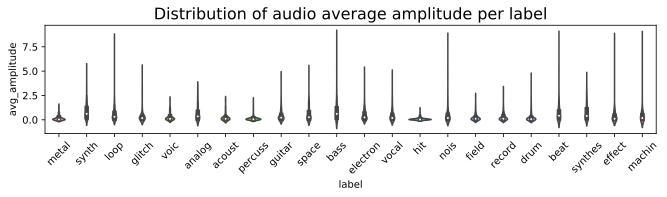

In [46]:
train_df['avg_amplitude'] = train_df['fname'].apply(lambda f: avg_amplitude(os.path.join(train_wav_trim_dir, f.split('.wav')[0] + '.wav')))

_, ax = plt.subplots(figsize=(11, 2))
sns.violinplot(ax=ax, x='label', y='avg_amplitude', data=train_df)

plt.xticks(rotation=45)
plt.title('Distribution of audio average amplitude per label', fontsize=16)
plt.show()

## 4.5 Training set average mfcc distribution

In [47]:
def avg_mfcc(file):
    y, sr = librosa.load(file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = config.n_mfcc)
    return (mfcc.mean())

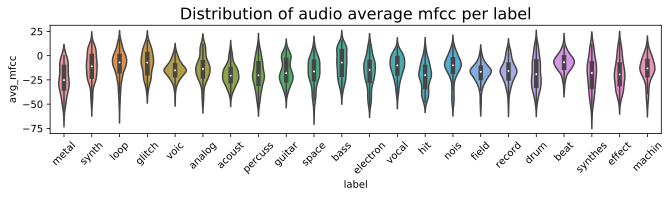

In [48]:
train_df['avg_mfcc'] = train_df['fname'].apply(lambda f: avg_mfcc(os.path.join(train_wav_trim_dir, f.split('.wav')[0] + '.wav')))

_, ax = plt.subplots(figsize=(11, 2))
sns.violinplot(ax=ax, x='label', y='avg_mfcc', data=train_df)

plt.xticks(rotation=45)
plt.title('Distribution of audio average mfcc per label', fontsize=16)
plt.show()

## 4.6 Visulize the spectrogram
- https://librosa.org/doc/main/generated/librosa.feature.chroma_stft.html
- https://www.cnblogs.com/xingshansi/p/6816308.html
- https://www.cnblogs.com/LXP-Never/p/11561355.html
- https://www.pianshen.com/article/4851367734/

train_wav_trim/4-4103_6997-hq.wav
<class 'numpy.ndarray'> <class 'int'>
(66364,) 22050


/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


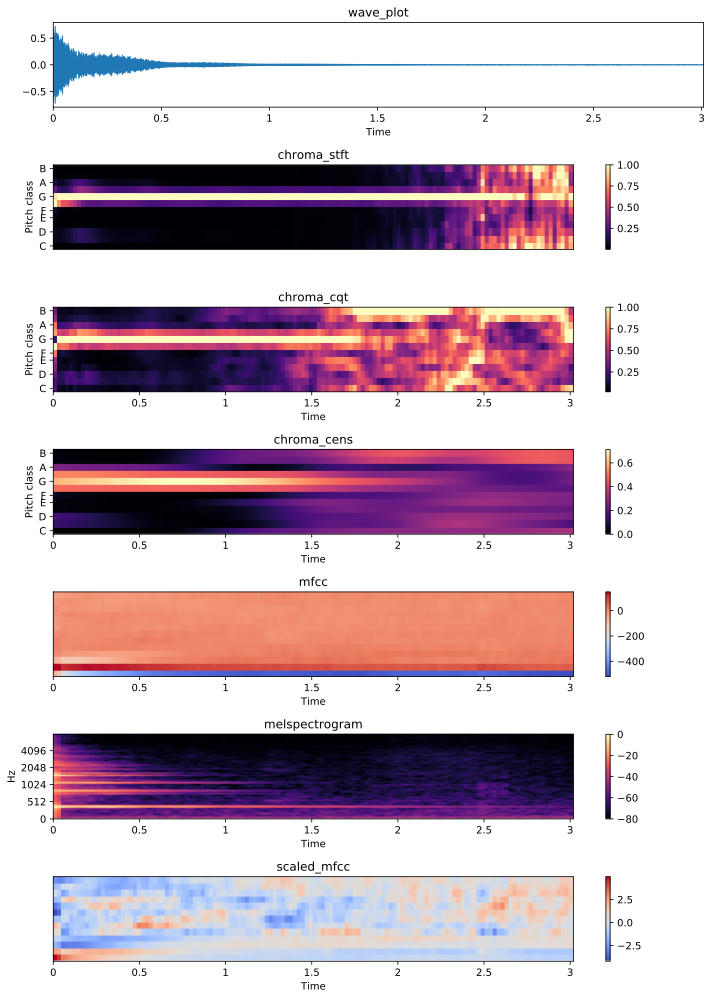

In [49]:
show_exmp(train_wav_trim_dir, train_ados, 9)

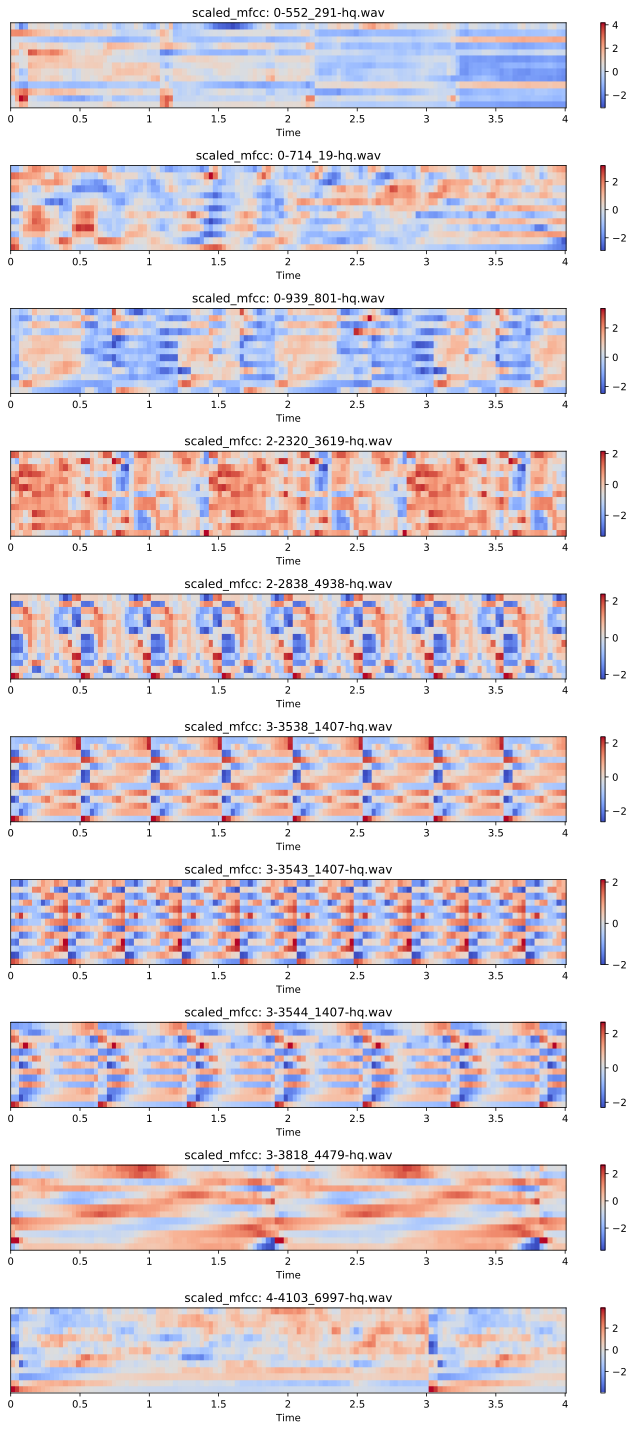

In [50]:
plot_scaled_mfcc(X_train, train_ados, 10, True)

# 5. Encode data

## 5.1 Encode labels

In [51]:
encoder = MultiLabelBinarizer()
encoder.fit(train_tags)
X_train_labels = encoder.transform(train_tags)

print('Number of class: ', len(encoder.classes_))

print('Labels: ', end = '')
for _ in encoder.classes_:
    print(_, end = ', ')
print()

Number of class:  22
Labels: acoust, analog, bass, beat, drum, effect, electron, field, glitch, guitar, hit, loop, machin, metal, nois, percuss, record, space, synth, synthes, vocal, voic, 


## 5.2 Normalization training set

13 126


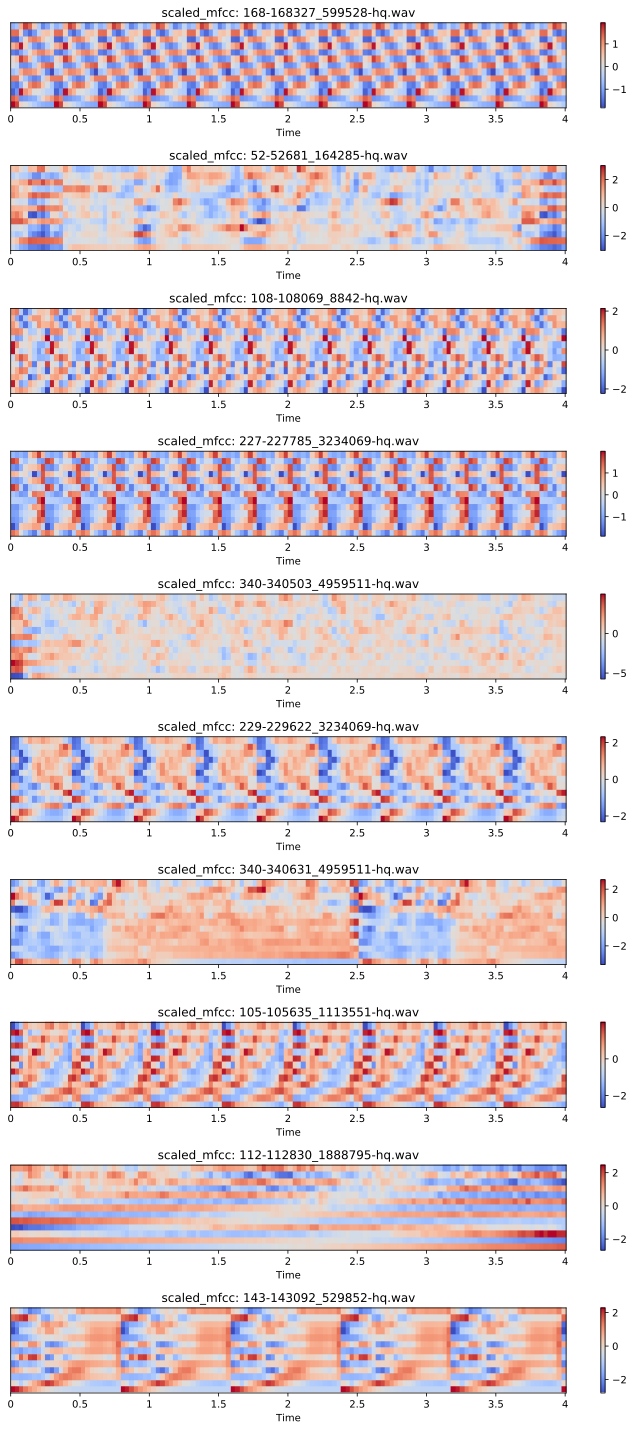

In [52]:
X_test_scaled = []
print(len(X_test[0]), len(X_test[0][0]))
for row in X_test:
    # row: n_mfcc * duration
    
    tmp = row.reshape(config.n_mfcc, config.audio_length)
    # scale mfcc alomg duration direction
    mfccs = sklearn.preprocessing.scale(tmp, axis=1)
    
    X_test_scaled.append(mfccs)

plot_scaled_mfcc(X_test_scaled, test_ados, 10, False)

13 126


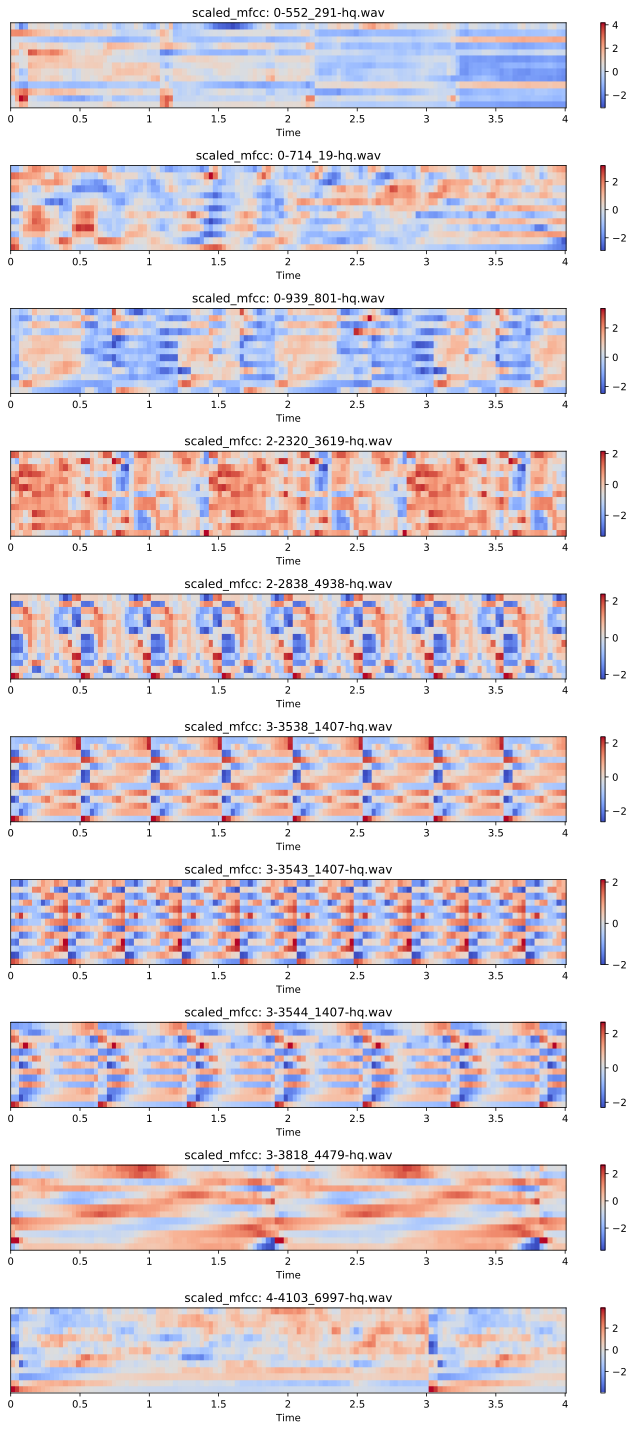

In [53]:
X_train_scaled = []
print(len(X_train[0]), len(X_train[0][0]))
for row in X_train:
    # row: n_mfcc * duration
    
    tmp = row.reshape(config.n_mfcc, config.audio_length)
    # scale mfcc alomg duration direction
    mfccs = sklearn.preprocessing.scale(tmp, axis=1)
    
    X_train_scaled.append(mfccs)

plot_scaled_mfcc(X_train_scaled, train_ados, 10, False)

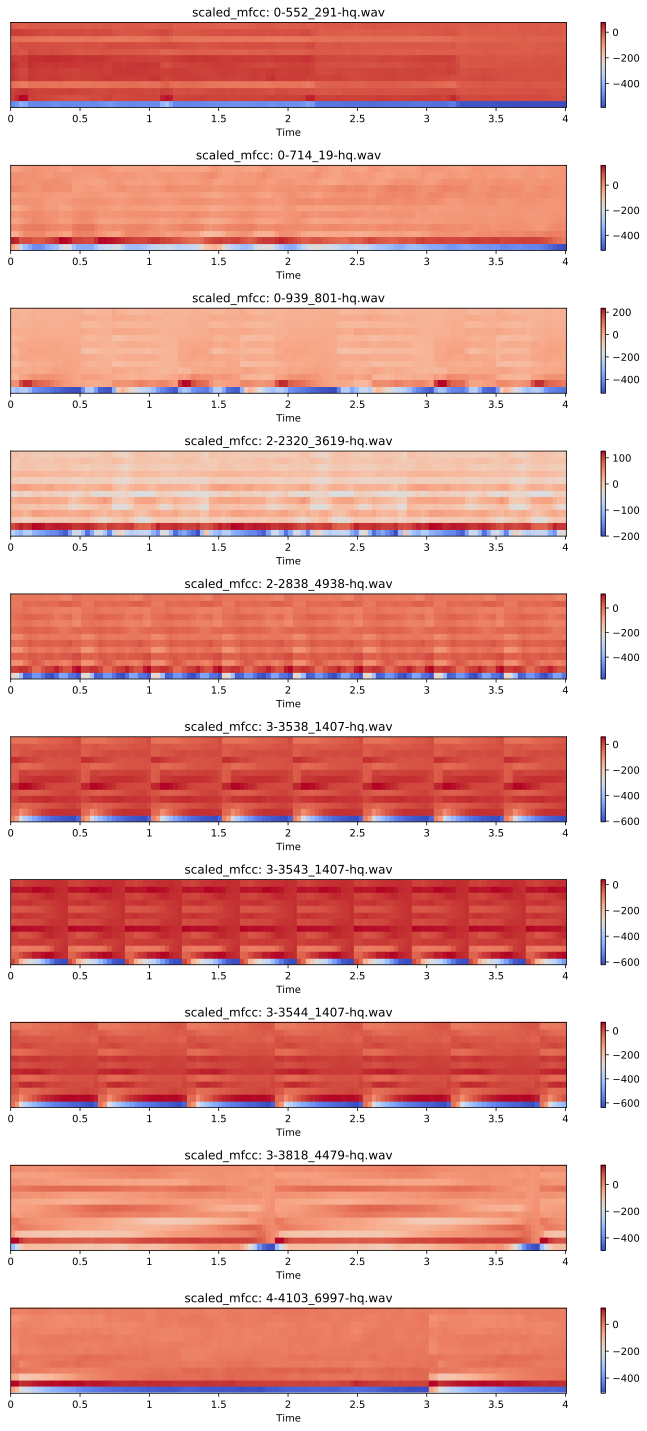

In [54]:
plot_scaled_mfcc(X_train, train_ados, 10, False)

# 6. CNN-based Method
## 6.1 Model 1: complex_conv_model

In [55]:
def complex_conv_model(config):
    
    inp = Input(shape=(config.n_mfcc, config.audio_length,1))
#     inp = Input(shape=(config.audio_length, config.n_mfcc,1))
    
    x = Convolution2D(32, (4,4), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*2, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(2, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [56]:
model_comp = complex_conv_model(config)
model_comp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13, 126, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 13, 126, 32)       544       
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 126, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 13, 126, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 63, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 63, 64)         81984     
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 63, 64)         256   

In [57]:
callback = EarlyStopping(monitor='val_loss', patience=3)

In [58]:
tr_s = np.expand_dims(X_train_scaled, axis=-1)
te_s = np.expand_dims(X_test_scaled, axis=-1)

print(len(X_train_scaled), len(X_train_scaled[0]), len(X_train_scaled[0][0]))
print(len(X_test_scaled), len(X_test_scaled[0]), len(X_test_scaled[0][0]))
print(len(tr_s), len(te_s))

1788 13 126
262 13 126
1788 262


In [59]:
tagnames = encoder.classes_
tagmodels = {}
for i,t in enumerate(tagnames):
    
    print('training {} - {}'.format(i, t))
    
    Y = X_train_labels[:,i].ravel()
    Y = to_categorical(Y, num_classes=2)

#     xtr, xte, ytr, yte = train_test_split(tr_s, Y, test_size=0.2, random_state=42)
    xtr, xte, ytr, yte = train_test_split(X_train, Y, test_size=0.2, random_state=42)
    
    model_comp = complex_conv_model(config)
    model_comp.fit(xtr, ytr, validation_data=(xte, yte),
                   batch_size=64, callbacks=callback, epochs=20)
    
    tagmodels[t] = model_comp

training 0 - acoust
Epoch 1/20
23/23 [==============================] - 7s 285ms/step - loss: 0.3750 - acc: 0.8951 - val_loss: 2.9217 - val_acc: 0.2318
Epoch 2/20
23/23 [==============================] - 6s 279ms/step - loss: 0.2202 - acc: 0.9399 - val_loss: 0.2175 - val_acc: 0.9609
Epoch 3/20
23/23 [==============================] - 7s 284ms/step - loss: 0.1847 - acc: 0.9399 - val_loss: 0.2166 - val_acc: 0.9609
Epoch 4/20
23/23 [==============================] - 8s 347ms/step - loss: 0.1809 - acc: 0.9385 - val_loss: 0.3628 - val_acc: 0.9609
Epoch 5/20
23/23 [==============================] - 8s 354ms/step - loss: 0.1625 - acc: 0.9420 - val_loss: 0.3533 - val_acc: 0.9609
Epoch 6/20
23/23 [==============================] - 10s 441ms/step - loss: 0.1551 - acc: 0.9399 - val_loss: 0.2762 - val_acc: 0.9609
training 1 - analog
Epoch 1/20
23/23 [==============================] - 10s 422ms/step - loss: 0.8359 - acc: 0.4573 - val_loss: 0.2730 - val_acc: 0.9274
Epoch 2/20
23/23 [================

Epoch 4/20
23/23 [==============================] - 6s 254ms/step - loss: 0.1701 - acc: 0.9441 - val_loss: 1.8212 - val_acc: 0.3408
Epoch 5/20
23/23 [==============================] - 6s 249ms/step - loss: 0.1514 - acc: 0.9455 - val_loss: 0.3243 - val_acc: 0.9358
Epoch 6/20
23/23 [==============================] - 6s 249ms/step - loss: 0.1372 - acc: 0.9510 - val_loss: 0.2161 - val_acc: 0.9190
Epoch 7/20
23/23 [==============================] - 6s 251ms/step - loss: 0.1259 - acc: 0.9559 - val_loss: 0.4083 - val_acc: 0.9358
Epoch 8/20
23/23 [==============================] - 6s 259ms/step - loss: 0.1168 - acc: 0.9573 - val_loss: 0.1766 - val_acc: 0.9190
Epoch 9/20
23/23 [==============================] - 6s 250ms/step - loss: 0.1032 - acc: 0.9573 - val_loss: 0.2578 - val_acc: 0.9302
Epoch 10/20
23/23 [==============================] - 6s 248ms/step - loss: 0.1123 - acc: 0.9545 - val_loss: 0.2104 - val_acc: 0.9190
Epoch 11/20
23/23 [==============================] - 6s 267ms/step - loss: 

23/23 [==============================] - 6s 262ms/step - loss: 0.2231 - acc: 0.9343 - val_loss: 1.2336 - val_acc: 0.3799
Epoch 5/20
23/23 [==============================] - 6s 261ms/step - loss: 0.2006 - acc: 0.9364 - val_loss: 0.4191 - val_acc: 0.8464
Epoch 6/20
23/23 [==============================] - 6s 269ms/step - loss: 0.1990 - acc: 0.9364 - val_loss: 0.3488 - val_acc: 0.8408
Epoch 7/20
23/23 [==============================] - 6s 260ms/step - loss: 0.1937 - acc: 0.9357 - val_loss: 0.4587 - val_acc: 0.8380
Epoch 8/20
23/23 [==============================] - 6s 271ms/step - loss: 0.1798 - acc: 0.9385 - val_loss: 0.2791 - val_acc: 0.9078
Epoch 9/20
23/23 [==============================] - 6s 262ms/step - loss: 0.1725 - acc: 0.9385 - val_loss: 0.3440 - val_acc: 0.8827
Epoch 10/20
23/23 [==============================] - 6s 263ms/step - loss: 0.1614 - acc: 0.9455 - val_loss: 0.3643 - val_acc: 0.8436
Epoch 11/20
23/23 [==============================] - 6s 269ms/step - loss: 0.1569 - ac

In [60]:
train_predscore = zeros(shape=(len(tr_s), len(tagnames)))

for i,t in enumerate(tagnames):
#     tmp = tagmodels[t].predict(tr_s, use_multiprocessing=True, workers=6, verbose=1)
    tmp = tagmodels[t].predict(X_train, use_multiprocessing=True, workers=6, verbose=1)

    tmp_t = [x[1] for x in tmp]
    train_predscore[:,i] = tmp_t

56/56 [==============================] - 2s 38ms/step


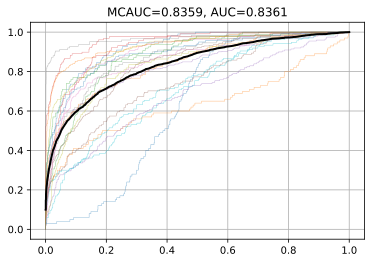

In [61]:
plt.figure(0)
plot_roc(tagnames, X_train_labels, train_predscore)

In [62]:
test_predscore = zeros(shape=(len(te_s), len(tagnames)))

for i,t in enumerate(tagnames):
#     tmp = tagmodels[t].predict(te_s, use_multiprocessing=True, workers=6, verbose=1)
    tmp = tagmodels[t].predict(X_test, use_multiprocessing=True, workers=6, verbose=1)
    tmp_t = [x[1] for x in tmp]
    test_predscore[:,i] = tmp_t

write_csv_kaggle_tags("conv_comp_not_scale_pad_itself.csv", tagnames, test_predscore)

9/9 [==============================] - 0s 38ms/step


## 6.2 Model 2: simple_conv_model

In [63]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
    
def simp_conv_model(config):
    model = Sequential()
#     inp = (config.dim[0], config.dim[1], 1)
    inp = (config.n_mfcc, config.audio_length, 1)
    
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape = inp))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2)) 
    
    model.add(Convolution2D(32, (3, 3),  activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    
    opt = optimizers.Adam(config.learning_rate)
    
    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [64]:
model_simp = simp_conv_model(config)
model_simp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 11, 124, 32)       320       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 5, 62, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 62, 32)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 3, 60, 32)         9248      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 1, 30, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 30, 32)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 960)               0

In [65]:
tagnames = encoder.classes_
tagmodels = {}
for i,t in enumerate(tagnames):
    
    print('training {} - {}'.format(i, t))
    
    Y = X_train_labels[:,i].ravel()
    Y = to_categorical(Y, num_classes=2)

#     xtr, xte, ytr, yte = train_test_split(tr_s, Y, test_size=0.2, random_state=42)
    xtr, xte, ytr, yte = train_test_split(X_train, Y, test_size=0.2, random_state=42)
    
    model_simp = simp_conv_model(config)
    model_simp.fit(xtr, ytr, validation_data=(xte, yte),
                   batch_size=64, callbacks=callback, epochs=20)
    
    tagmodels[t] = model_simp

training 0 - acoust
Epoch 1/20
23/23 [==============================] - 2s 51ms/step - loss: 5.2755 - acc: 0.8825 - val_loss: 0.3446 - val_acc: 0.9581
Epoch 2/20
23/23 [==============================] - 1s 46ms/step - loss: 1.0417 - acc: 0.8643 - val_loss: 0.2245 - val_acc: 0.9581
Epoch 3/20
23/23 [==============================] - 1s 54ms/step - loss: 0.6016 - acc: 0.9154 - val_loss: 0.1847 - val_acc: 0.9525
Epoch 4/20
23/23 [==============================] - 1s 44ms/step - loss: 0.4011 - acc: 0.9000 - val_loss: 0.2256 - val_acc: 0.9581
Epoch 5/20
23/23 [==============================] - 1s 45ms/step - loss: 0.3267 - acc: 0.9056 - val_loss: 0.1952 - val_acc: 0.9609
Epoch 6/20
23/23 [==============================] - 1s 39ms/step - loss: 0.2651 - acc: 0.9224 - val_loss: 0.2641 - val_acc: 0.9553
training 1 - analog
Epoch 1/20
23/23 [==============================] - 2s 58ms/step - loss: 7.2276 - acc: 0.9028 - val_loss: 2.1781 - val_acc: 0.9330
Epoch 2/20
23/23 [=========================

23/23 [==============================] - 1s 35ms/step - loss: 0.2570 - acc: 0.9315 - val_loss: 0.2870 - val_acc: 0.9274
Epoch 11/20
23/23 [==============================] - 1s 37ms/step - loss: 0.2492 - acc: 0.9245 - val_loss: 0.2996 - val_acc: 0.9190
Epoch 12/20
23/23 [==============================] - 1s 39ms/step - loss: 0.2099 - acc: 0.9322 - val_loss: 0.2645 - val_acc: 0.9302
Epoch 13/20
23/23 [==============================] - 1s 48ms/step - loss: 0.2254 - acc: 0.9301 - val_loss: 0.2656 - val_acc: 0.9274
Epoch 14/20
23/23 [==============================] - 1s 41ms/step - loss: 0.2217 - acc: 0.9294 - val_loss: 0.2934 - val_acc: 0.9302
Epoch 15/20
23/23 [==============================] - 1s 37ms/step - loss: 0.2163 - acc: 0.9343 - val_loss: 0.2945 - val_acc: 0.9330
training 14 - nois
Epoch 1/20
23/23 [==============================] - 1s 41ms/step - loss: 3.9846 - acc: 0.7916 - val_loss: 0.9855 - val_acc: 0.9022
Epoch 2/20
23/23 [==============================] - 1s 36ms/step - los

In [66]:
train_predscore = zeros(shape=(len(tr_s), len(tagnames)))

for i,t in enumerate(tagnames):
#     tmp = tagmodels[t].predict(tr_s, use_multiprocessing=True, workers=6, verbose=1)
    tmp = tagmodels[t].predict(X_train, use_multiprocessing=True, workers=6, verbose=1)
    tmp_t = [x[1] for x in tmp]
    train_predscore[:,i] = tmp_t

56/56 [==============================] - 0s 4ms/step


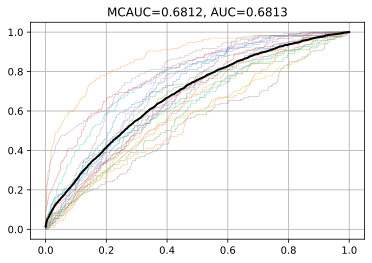

In [67]:
plt.figure(0)
plot_roc(tagnames, X_train_labels, train_predscore)

In [68]:
test_predscore = zeros(shape=(len(te_s), len(tagnames)))

for i,t in enumerate(tagnames):
#     tmp = tagmodels[t].predict(te_s, use_multiprocessing=True, workers=6, verbose=1)
    tmp = tagmodels[t].predict(X_test, use_multiprocessing=True, workers=6, verbose=1)
    tmp_t = [x[1] for x in tmp]
    test_predscore[:,i] = tmp_t

write_csv_kaggle_tags("conv_simp_not_scale_pad_itself.csv", tagnames, test_predscore)

9/9 [==============================] - 0s 4ms/step


# 7. In-class Methods

## 7.1 Tag pre-processing
Next, we extract all the tags from the data, and get a unique list of tags.

In [69]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)

Now we convert the list of tags for each sound into binary attributes.

In [70]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

In [71]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
# 1788 * 22
train_classes = tags2class(train_tags, tagnames)

## 7.2 Baseline

In [72]:
tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    lr = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, class_weight='balanced', solver='liblinear')
    lr.fit(train_Xtf, myY)
    tagmodels[t] = lr

training 0 - acoust
training 1 - analog
training 2 - bass
training 3 - beat
training 4 - drum
training 5 - effect
training 6 - electron
training 7 - field
training 8 - glitch
training 9 - guitar
training 10 - hit
training 11 - loop
training 12 - machin
training 13 - metal
training 14 - nois
training 15 - percuss
training 16 - record
training 17 - space
training 18 - synth
training 19 - synthes
training 20 - vocal
training 21 - voic


- To see how we did on tagging the training set, we compute the tag scores.
- And then plot the ROC curve using the training classes and training predicted scores.
- Note that AUC is the AUC of the black curve, while MCAUC is the average of the AUCs for all the color curves.

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


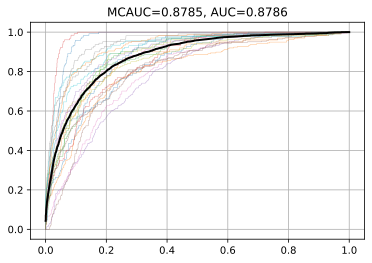

In [73]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp
    
# Bow 100: MCAUC = 0.8409, AUC = 0.8410
# Bow 200: MCAUC = 0.9026, AUC = 0.9027
plot_roc(tagnames, train_classes, train_predscore)

Now apply the LR classifiers to the test set to predict the score for each tag.

In [75]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))

#     tmp = tagmodels[t].decision_function(test_Xtf)
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


Now write the tag scores for the test set for submission to Kaggle.

In [76]:
write_csv_kaggle_tags("LR_baseline.csv", tagnames, test_predscore)

## 7.3 MLP Classifier

In [78]:
from sklearn.neural_network import MLPClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    parameters = {'hidden_layer_sizes': np.array([(100, 10), (100,), (50, 50)]),
                  'learning_rate': np.array(['constant', 'invscaling', 'adaptive'])}
    
    mlp = GridSearchCV(MLPClassifier(), parameters, cv=5, n_jobs=-1, verbose=False)
    mlp.fit(train_Xtf, myY)
    tagmodels[t] = mlp.best_estimator_

training 0 - acoust


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 1 - analog


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 2 - bass


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 3 - beat
training 4 - drum


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 5 - effect


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 6 - electron


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 7 - field


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 8 - glitch
training 9 - guitar


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 10 - hit


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 11 - loop


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 12 - machin
training 13 - metal


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 14 - nois


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys
/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 15 - percuss


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 16 - record


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 17 - space


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 18 - synth


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 19 - synthes


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


training 20 - vocal
training 21 - voic


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


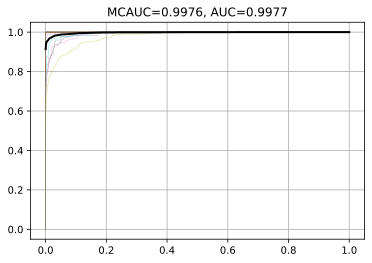

In [79]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [80]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [81]:
write_csv_kaggle_tags("MLP_bow.csv", tagnames, test_predscore)

## 7.4 SVC Classifier

In [82]:
from sklearn.svm import SVC

tagmodels = {}
for i,t in enumerate(tagnames):
    print('training {} - {}'.format(i, t))
    myY = train_classes[:,i].ravel()
    parameters = {'C': np.logspace(-4,4,10)}
    
    svc = GridSearchCV(SVC(class_weight='balanced'),
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    svc.fit(train_Xtf, myY)
    tagmodels[t] = svc.best_estimator_

training 0 - acoust
training 1 - analog
training 2 - bass
training 3 - beat
training 4 - drum
training 5 - effect
training 6 - electron
training 7 - field
training 8 - glitch
training 9 - guitar
training 10 - hit
training 11 - loop
training 12 - machin
training 13 - metal
training 14 - nois
training 15 - percuss
training 16 - record
training 17 - space
training 18 - synth
training 19 - synthes
training 20 - vocal
training 21 - voic


predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


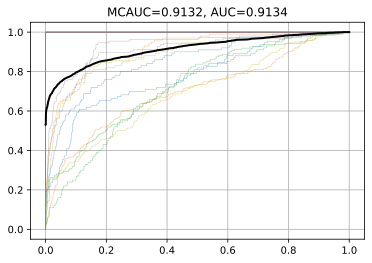

In [83]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [84]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [85]:
write_csv_kaggle_tags("SVC_bow.csv", tagnames, test_predscore)

## 7.5 Random Forest Classifier

In [86]:
from sklearn.ensemble import RandomForestClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'n_estimators': np.array([100, 150, 180, 200, 300])}
    
    rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                      parameters, cv=5, n_jobs=-1, verbose=False)
    
    rf.fit(train_Xtf, myY)
    tagmodels[t] = rf.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


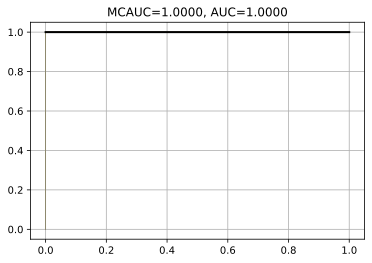

In [87]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [88]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [89]:
write_csv_kaggle_tags("RandomForest_bow.csv", tagnames, test_predscore)

## 7.6 KNeighbors Classifier

In [90]:
from sklearn.neighbors import KNeighborsClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'n_neighbors': np.array([1, 3, 5, 10, 15]),
                  'weights': np.array(['uniform', 'distance'])}
    
    knc = GridSearchCV(KNeighborsClassifier(algorithm = 'auto'), 
                      parameters, cv=5, n_jobs=-1, verbose=False)
    
    knc.fit(train_Xtf, myY)
    tagmodels[t] = knc.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


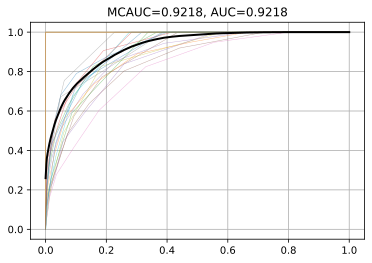

In [91]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [92]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [93]:
write_csv_kaggle_tags("KNerghbor_bow.csv", tagnames, test_predscore)

## 7.7 Decision Tree Classifier

In [94]:
from sklearn.tree import DecisionTreeClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'splitter': np.array(['best', 'random'])}
    
    dtc = GridSearchCV(DecisionTreeClassifier(), 
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    dtc.fit(train_Xtf, myY)
    tagmodels[t] = dtc.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


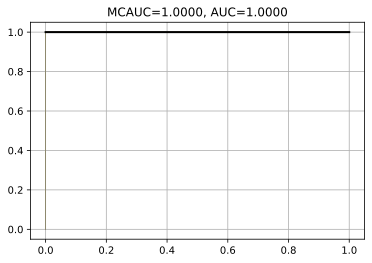

In [95]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [96]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [97]:
write_csv_kaggle_tags("DecisionTree_bow.csv", tagnames, test_predscore)

## 7.8 AdaBoost Classifier

In [98]:
from sklearn.ensemble import AdaBoostClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'n_estimators': np.array([30, 50, 80, 100, 150])}
    
    abc = GridSearchCV(AdaBoostClassifier(random_state = 1), 
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    abc.fit(train_Xtf, myY)
    tagmodels[t] = abc.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


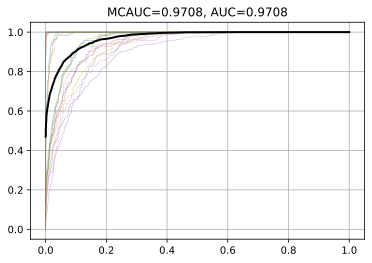

In [99]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [100]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [101]:
write_csv_kaggle_tags("AdaBoost_bow.csv", tagnames, test_predscore)

## 7.9 GradientBoost Classifier

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'n_estimators': np.array([30, 50, 80, 100, 150]),
                  'learning_rate': np.array([0.01, 0.1, 0.001])}
    
    gbc = GridSearchCV(GradientBoostingClassifier(random_state = 1), 
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    gbc.fit(train_Xtf, myY)
    tagmodels[t] = gbc.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


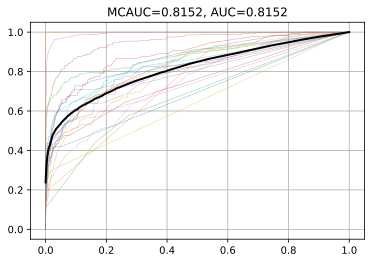

In [103]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [104]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [105]:
write_csv_kaggle_tags("GradientBoost_bow.csv", tagnames, test_predscore)

## 7.10 SGD Classifier

In [106]:
from sklearn.linear_model import SGDClassifier

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {'loss': np.array(['hinge', 'log', 'modified_huber', 'squared_hinge',
                                    'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 
                                    'squared_epsilon_insensitive'])}
    
    sgd = GridSearchCV(SGDClassifier(random_state = 1), 
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    sgd.fit(train_Xtf, myY)
    tagmodels[t] = sgd.best_estimator_

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


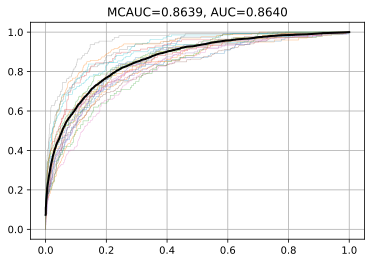

In [107]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(train_Xtf)
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [108]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].decision_function(test_Xtf)
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [109]:
write_csv_kaggle_tags("SGD_bow.csv", tagnames, test_predscore)

## 7.11 QuadraticDiscriminantAnalysis Classifier

In [110]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

tagmodels = {}
for i,t in enumerate(tagnames):
    myY = train_classes[:,i].ravel()
    parameters = {}
    
    qda = GridSearchCV(QuadraticDiscriminantAnalysis(), 
                       parameters, cv=5, n_jobs=-1, verbose=False)
    
    qda.fit(train_Xtf, myY)
    tagmodels[t] = qda.best_estimator_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.7/site-

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


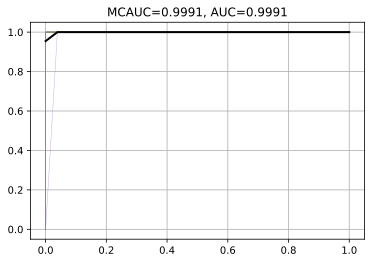

In [111]:
train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(train_Xtf)[:, 1]
    train_predscore[:,i] = tmp

plot_roc(tagnames, train_classes, train_predscore)

In [112]:
test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))

for i,t in enumerate(tagnames):
    print('predicting {} - {}'.format(i, t))
    tmp = tagmodels[t].predict_proba(test_Xtf)[:, 1]
    test_predscore[:,i] = tmp

predicting 0 - acoust
predicting 1 - analog
predicting 2 - bass
predicting 3 - beat
predicting 4 - drum
predicting 5 - effect
predicting 6 - electron
predicting 7 - field
predicting 8 - glitch
predicting 9 - guitar
predicting 10 - hit
predicting 11 - loop
predicting 12 - machin
predicting 13 - metal
predicting 14 - nois
predicting 15 - percuss
predicting 16 - record
predicting 17 - space
predicting 18 - synth
predicting 19 - synthes
predicting 20 - vocal
predicting 21 - voic


In [113]:
write_csv_kaggle_tags("QuadraticDiscriminantAnalysis_bow.csv", tagnames, test_predscore)